# NMR Inversion Recovery homework

<strong>Author(s):</strong> Seth D. Veenbaas, Jessica A. Nash, The Molecular Sciences Software Institute

<div class="alert alert-block alert-info"> 
<h2>Overview</h2>

<strong>Objective:</strong>

* Use Pandas and Scipy to proceed NMR data.

* Calculate the $T_1$ relaxation times.

* Determine if solvent conditions affect $T_1$ relaxation times.

</div>

## Inversion recovery experiment
The inversion-recovery experiment measures $T_1$ relaxation times of any nucleus. If the net magnetization is placed along the -z axis, it will gradually return to its equilibrium position along the +z axis at a rate governed by $T_1$. The equation governing this behavior as a function of the time t after its displacement is: 

$$ M_z(t) = M_{z,\text{eq}} \cdot \left(1 - 2e^{-t/T_1}\right) $$

The basic pulse sequence consists of an 180<sup>°</sup> pulse that inverts the magnetization to the -z axis. During the following delay, relaxation along the longitudinal plane takes place. Magnetization comes back to the original equilibrium z-magnetization. A 90<sup>°</sup> pulse creates transverse magnetization. The experiment is repeated for a series of delay values taken from a variable delay list. A 1D spectrum is obtained for each value of vd and stored in a pseudo 2D dataset. The longer the relaxation delay (d<sub>1</sub>) is, the more precise the T<sub>1</sub> measurement is. An ideal relaxation time (d<sub>1</sub>) can be calculated (aq = acquisition time):

 $$ d_1 + \text{aq} = 5 \cdot T_1 $$

 <br>

![image.png](../images/t1_relaxation_pulse_sequence.png)

More information:
https://imserc.northwestern.edu/downloads/nmr-t1.pdf



## Importing Required Libraries

First, let's import the python libraries/packages we need to work with the data.

In [57]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import mnova

%config InteractiveShell.ast_node_interactivity = 'all'

Let's load, reformat, and view our data for an Ibuprofen inversion recovery experiment in chloroform (CDCl3).

<Axes: xlabel='Time(s)'>

,Time(s),7.2_ppm,7.1_ppm,3.7_ppm,2.5_ppm,1.9_ppm,1.5_ppm,0.9_ppm
1,0.05,-162885.324219,-162306.769043,-80722.982422,-153871.150391,-79104.215332,-216684.112305,-458164.314941
2,0.11,-154924.758789,-153773.737305,-76314.500977,-138198.976562,-74199.250000,-180093.169434,-408792.754395
3,0.23,-139766.524414,-137715.460693,-67926.022461,-109190.863525,-64802.323730,-114482.992676,-315141.228027
4,0.46,-112673.046997,-109142.054810,-53136.028320,-60301.979492,-48382.227295,-12551.293945,-160680.295898
5,0.92,-65336.167755,-59692.360199,-27959.349976,15407.574280,-21192.122742,122369.145996,74055.751282
6,1.85,8071.924713,15549.150330,9709.402313,107688.948547,18421.157410,243767.761017,350442.999664
7,3.70,97173.973541,103652.861496,53605.191887,175717.667595,60838.095512,293242.782425,542746.559494
8,7.40,167925.430847,170277.066399,86591.555096,194679.631977,89561.661911,295919.938602,595652.451015
9,11.80,189287.266422,189341.277565,95679.004642,194466.024364,97117.970740,294862.126953,598987.454239
10,16.00,193965.925606,193293.661484,97310.812466,194105.469505,98653.014368,294625.451290,599892.310078


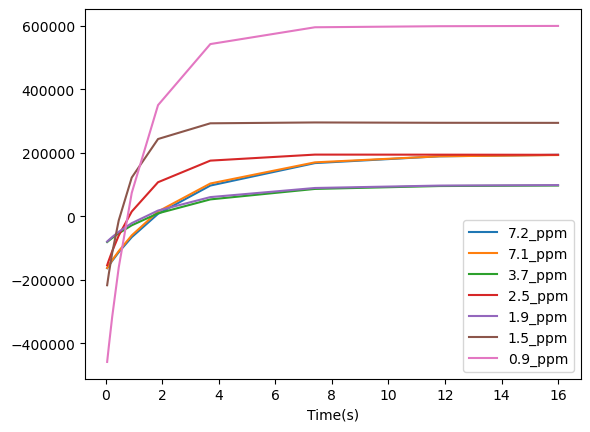

In [58]:
# Load the data from the CSV file
ibuprofen_cdcl3_inversion_data = pd.read_csv('data/Ibuprofen_CDCl3_1H_inversion_recovery.csv', header=1)

# Runs reformating function
ibuprofen_cdcl3_inversion_data = mnova.rename_columns(ibuprofen_cdcl3_inversion_data)

# Plot inversion recovery data
ibuprofen_cdcl3_inversion_data.plot(x='Time(s)')

# Display the inversion recovery dataframe
ibuprofen_cdcl3_inversion_data

## The Effect of Solvent on NMR $T_1$ Relaxation

NMR T₁ relaxation times are influenced by the choice of solvent due to differences in molecular tumbling, viscosity, and solvent-solute interactions.

Let's compare the differences in $T_1$ relaxation for Ibuprofen in deuterated chloroform (CDCl<sub>3</sub>) vs. deuterated DMSO (DMSO-d<sub>6</sub>).


<div class="alert alert-block alert-warning">
<h3>Step 1</h3>

Load, reformat, and view the inversion recovery data for ibuprofen in DMSO (DMSO-d<sub>6</sub>).

- Load data from `'data/Ibuprofen_DMSO_1H_inversion_recovery.csv'`
- Save the data to a variable named: `ibuprofen_dmso_inversion_data`

</div>

<Axes: xlabel='Time(s)'>

,Time(s),7.2_ppm,7.1_ppm,3.6_ppm,2.4_ppm,1.8_ppm,1.3_ppm,0.8_ppm
1,0.10,-16102.050598,-15713.197144,-34597.998535,-12972.247925,-7825.968750,-17466.676147,-38758.348206
2,0.25,-13059.239502,-12404.798676,-25659.125946,-6706.596863,-5775.524780,-6449.338745,-20852.475220
3,0.55,-7766.800491,-6732.130234,-10434.171463,2590.639938,-2425.889801,8731.601181,5986.945831
4,1.10,-277.281349,1078.877708,9604.268150,12315.373886,1842.123711,22741.671280,34936.701515
5,2.30,9748.840378,11010.249981,32586.499405,19524.680889,6981.385956,30707.920155,57342.421673
6,4.60,17531.912342,18086.755459,45252.167183,20960.685307,10115.998333,31635.017700,63094.367981
7,9.20,20579.497609,20538.858282,47878.467003,20874.074663,11035.491863,31502.789746,63304.683034
8,18.50,20904.816264,20728.201382,48107.889511,20874.399755,11103.484433,31502.968805,63309.278610
9,29.50,20901.395061,20731.698857,48249.084908,20891.361219,11117.568182,31506.709575,63314.050830
10,40.00,20899.547291,20725.268463,48090.923836,20889.820976,11112.380916,31502.865590,63275.947369


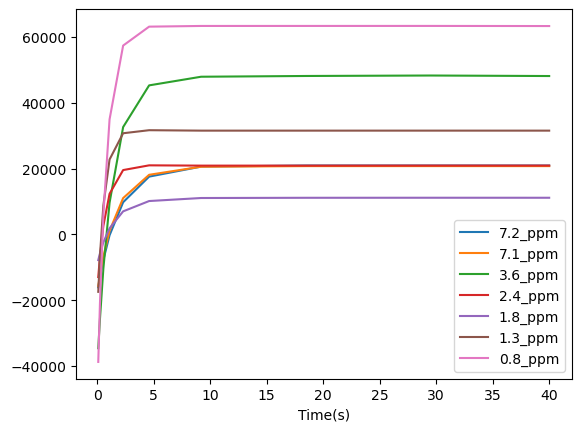

In [59]:
# Load the data from the Condition X CSV file
ibuprofen_dmso_inversion_data = pd.read_csv('data/Ibuprofen_DMSO_1H_inversion_recovery.csv', header=1)

# Runs reformating function
ibuprofen_dmso_inversion_data = mnova.rename_columns(ibuprofen_dmso_inversion_data)

# Plot inversion recovery data
ibuprofen_dmso_inversion_data.plot(x='Time(s)')

# Display the inversion recovery dataframe
ibuprofen_dmso_inversion_data

Let's define the functions you'll need to calculate $T_1$!

In [60]:
# Define the inversion recovery model with the parameters (M, T1, and C)
def inversion_recovery_model(time, M, T1, C):
    return M * (1 - 2 * np.exp(-time / T1)) + C

# Define function to fit data to a inversion recovery model
def fit_relaxation_data(time_data, peak_data):
    # Initial guess for M, T1, and C
    initial_guess = [max(peak_data), 1.0, min(peak_data)]
    
    # Fit the curve
    param_optimal, _ = curve_fit(inversion_recovery_model, time_data, peak_data, p0=initial_guess)
    
    return param_optimal

<div class="alert alert-block alert-warning">
<h3>Step 2</h3>

We need to use following `for` loop for each of our data sets. Modify the code in the following cell to be a reusable function. Incorporate the follow:

#### 1. Function Name: `calc_t1`

#### 2. Parameters:

- `df` (DataFrame): Inversion recovery data.

#### 3. Function body (indented code):

```python
# Create an empty DataFrame for t1_data with columns 'Peak' and 'T1(s)'
t1_data = pd.DataFrame(columns=['Peak', 'T1(s)'])

# Calculate T1 for each peak and plot the fit
for column in df.columns[1:]:
    
    # Fit relaxation data to calculate T1
    time_data = df['Time(s)']
    peak_data = df[column]
    param_optimal = fit_relaxation_data(time_data, peak_data)
    T1 = param_optimal[1]
    
    # Add T1 time to the t1_data DataFrame
    new_row = pd.DataFrame({'Peak': [column], 'T1(s)': [T1]})
    t1_data = pd.concat([t1_data, new_row], ignore_index=True)
```

#### 4. Return:

- `t1_data` (DataFrame): $T_1$ relaxation times for every NMR peak.

</div>

### Here is what it looks like to define a function:
```python
def function_name(parameters):
    # Optional: explain what your function does in a Docstring
    """
    Docstring
    """
    # Function body (indented code)
    return output  # Optional: Return a result
```

In [61]:
# Calculate T1 times from data in a Dataframe    
def calc_t1(df):    
    # Create an empty DataFrame for t1_data with columns 'Peak' and 'T1(s)'
    t1_data = pd.DataFrame(columns=['Peak', 'T1(s)'])
    
    # Calculate T1 for each peak and plot the fit
    for column in df.columns[1:]:
        
        # Fit relaxation data to calculate T1
        time_data = df['Time(s)']
        peak_data = df[column]
        param_optimal = fit_relaxation_data(time_data, peak_data)
        T1 = param_optimal[1]
        
        # Add T1 time to the t1_data DataFrame
        new_row = pd.DataFrame({'Peak': [column], 'T1(s)': [T1]})
        t1_data = pd.concat([t1_data, new_row], ignore_index=True)
    
    return t1_data
    

<div class="alert alert-block alert-warning">
<h3>Step 3</h3>

Use your `calc_t1` function to calculate $T_1$ times for ibuprofen in each of the solvent conditions and save the results to the variables:
* `ibuprofen_cdcl3_t1_data`
* `ibuprofen_dmso_t1_data`

Display the results.

</div>

In [62]:
# Calculate T1 ibuprofen_cdcl3_inversion_data
ibuprofen_cdcl3_t1_data = calc_t1(ibuprofen_cdcl3_inversion_data)

# Calculate T1 ibuprofen_dmso_inversion_data
ibuprofen_dmso_t1_data = calc_t1(ibuprofen_dmso_inversion_data)

/tmp/ipykernel_65645/2537481625.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t1_data = pd.concat([t1_data, new_row], ignore_index=True)
/tmp/ipykernel_65645/2537481625.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t1_data = pd.concat([t1_data, new_row], ignore_index=True)


In [63]:
# display ibuprofen_cdcl3_t1_data Dataframe
ibuprofen_cdcl3_t1_data

,Peak,T1(s)
0,7.2_ppm,2.786373
1,7.1_ppm,2.619260
2,3.7_ppm,2.560650
3,2.5_ppm,1.301957
4,1.9_ppm,2.276989
5,1.5_ppm,0.800956
6,0.9_ppm,1.242966


In [64]:
# display ibuprofen_dmso_t1_data Dataframe
ibuprofen_dmso_t1_data

,Peak,T1(s)
0,7.2_ppm,1.823413
1,7.1_ppm,1.647562
2,3.6_ppm,1.310063
3,2.4_ppm,0.727594
4,1.8_ppm,1.417718
5,1.3_ppm,0.585236
6,0.8_ppm,0.780297


<div class="alert alert-block alert-warning">
<h3>Step 4</h3>

Use the Pandas `.describe()` method to compare the $T_1$ times in CDCl<sub>3</sub> and DMSO-d<sub>6</sub>.

</div>

In [65]:
# Describe the ibuprofen_cdcl3_t1_data
ibuprofen_cdcl3_t1_data.describe()

,T1(s)
count,7.000000
mean,1.941307
std,0.802794
min,0.800956
25%,1.272461
50%,2.276989
75%,2.589955
max,2.786373


In [66]:
# Describe the ibuprofen_dmso_t1_data
ibuprofen_dmso_t1_data.describe()

,T1(s)
count,7.000000
mean,1.184555
std,0.487178
min,0.585236
25%,0.753946
50%,1.310063
75%,1.532640
max,1.823413


<div class="alert alert-block alert-warning">
<h3>Step 5</h3>

Which solvent condition increased $T_1$ relaxation times the most?

What was the lowest $T_1$ time for peak 7.1_ppm?

</div>

In [68]:
condition = 'CDCl3'
lowest_T1_time_7_1_ppm = 1.6